## 스프린트 미션 #8
#### 3팀 전수현 
#### 제출일자: 25.07.11

football-semantic-segmentation(kaggle) 다운로드

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sadhliroomyprime/football-semantic-segmentation")

print("Path to dataset files:", path)

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/soohyun/.cache/kagglehub/datasets/sadhliroomyprime/football-semantic-segmentation/versions/1


## 0. Import Libraries

In [2]:
# ====================================================================
# STEP 0: Import Libraries
# ====================================================================
# 과제에 사용할 library들을 import

# 시스템 및 입출력 관련
import os  # 디렉토리, 파일 경로 조작 등
from PIL import Image  # 이미지 열기 및 처리 (Pillow)
from tqdm import tqdm  # 반복문의 진행 상태 시각화
from pathlib import Path  # payhon path


# 시각화 도구
import matplotlib.pyplot as plt  # 기본 시각화 라이브러리
import seaborn as sns  # 고급 시각화 (히트맵, 스타일 등)

# 이미지 처리
import cv2  # OpenCV - 고급 이미지/비디오 처리

# 수치 연산
import numpy as np  # 배열, 벡터 계산 등

# PyTorch 기본 구성
import torch  # 텐서, 연산 등
import torch.nn as nn  # 모델 정의 (layer, loss 등)
import torch.nn.functional as F
import torch.optim as optim  # Optimizer (SGD, Adam 등)

# PyTorch 데이터 처리
from torch.utils.data import Dataset, DataLoader  # 커스텀 데이터셋, 배치 로딩

# PyTorch 이미지 전처리
import torchvision
from torchvision import transforms  # 기본 이미지 transform
from torchvision import datasets  # torchvision 내장 데이터셋
import torchvision.models as models

from torchvision.transforms import v2  # torchvision v2 transforms (최신 API)

# 싸이킷런 평가 지표
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torchvision.models.detection.ssd import SSD300_VGG16_Weights

# 싸이킷런 데이터 나누기
from sklearn.model_selection import train_test_split

# 통계 tool
import pandas as pd

# 실험 추적 및 하이퍼파라미터 관리
import wandb  # Weights & Biases - 실험 로깅, 시각화, 하이퍼파라미터 튜닝

# Garbage Collector 모듈
import gc

# Data Augmentation 패키지: Albumentations
import albumentations as A

## 1. Set configuration

In [3]:
# ====================================================================
# STEP 1: Configuration 설정
# ====================================================================
# 하이퍼파라미터 및 경로 등 실험에 필요한 설정들을 모아둠
# 실험 추적 및 재현성을 위해 모든 값은 여기에서 수정하고자 함

# 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 주요 하이퍼파라미터
LEARNING_RATE = 1e-4  # 학습률 (optimizer용)
BATCH_SIZE = 16  # 배치 크기
NUM_EPOCHS = 100  # 학습 epoch 수
SEED = 42  # 재현성을 위한 random seed

# 데이터 경로 설정
# DATA_ROOT = path
# train_dir = os.path.join(DATA_ROOT, "train")
# val_dir = os.path.join(DATA_ROOT, "val")
# test_dir = os.path.join(DATA_ROOT, "test")

# 모델 설정
MODEL_NAME = "UNET"  # 또는 "EfficientNet", 등등
USE_PRETRAINED = True  # torchvision 모델 사용 여부

# 학습 고도화 설정 (Optional)
USE_SCHEDULER = True  # Learning rate scheduler 사용 여부
EARLY_STOPPING = True  # Early stopping 적용 여부
AUGMENTATION = True  # 데이터 증강 사용 여부

# 실험 로깅용 설정
USE_WANDB = True
WANDB_PROJECT = "football-semantic-segmentation"
RUN_NAME = f"{MODEL_NAME}_bs{BATCH_SIZE}_lr{LEARNING_RATE}"

Using device: cuda


## 2. Data pre-processing

먼저 데이터를 EDA해보면서 데이터를 파악하는 것이 우선이다. 코드잇에서 제공한 baseline코드를 바탕으로 데이터를 이해해보는 과정을 먼저 해당 노트북에 기록했다.

In [4]:
# 폴더 내 모든 파일 목록 가져오기
image_folder = os.path.join(path, "images")
file_list = os.listdir(image_folder)

# 원본 이미지(.jpg)와 fuse 이미지 매칭
image_list = sorted([f for f in file_list if f.endswith(".jpg")])
mask_list = sorted([f for f in file_list if "fuse" in f])

# 이미지 로드 및 확인
image_pairs = []
for orig_file in image_list:
    # 동일한 프레임의 fuse 파일 찾기
    base_name = orig_file.replace(".jpg", "")
    fuse_file = next((f for f in mask_list if base_name in f), None)

    if fuse_file:
        # 원본과 마스크 로드
        img_path = os.path.join(image_folder, orig_file)
        mask_path = os.path.join(image_folder, fuse_file)

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        if img is not None and mask is not None:
            image_pairs.append((img, mask))

# 최종적으로 로드된 이미지 쌍 개수 출력
print(f"{len(image_pairs)} pairs")

100 pairs


(1080, 1920, 3)
(1080, 1920, 3)


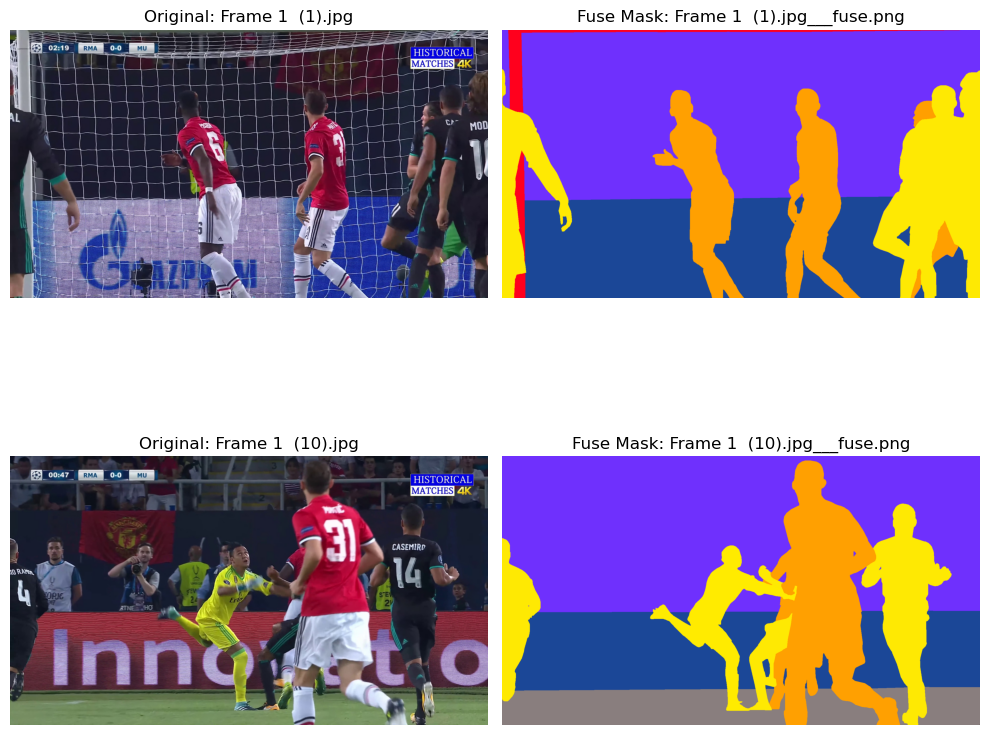

Frame 1  (10).jpg___fuse.png


In [5]:
# 샘플 이미지 출력해보기

sample_image_pairs = []
num_samples = 2

for orig_file in image_list[:num_samples]:
    base_name = orig_file.replace(".jpg", "")
    fuse_file = next((f for f in mask_list if base_name in f), None)

    if fuse_file:
        sample_image_pairs.append((orig_file, fuse_file))

# 이미지 5쌍 시각화
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

for i, (orig_file, fuse_file) in enumerate(sample_image_pairs):
    # 이미지 로드
    orig_img = cv2.imread(os.path.join(image_folder, orig_file))
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)  # OpenCV BGR → RGB 변환

    fuse_img = cv2.imread(os.path.join(image_folder, fuse_file))
    fuse_img = cv2.cvtColor(fuse_img, cv2.COLOR_BGR2RGB)  # 마스크도 RGB 변환
    print(orig_img.shape)

    # 시각화
    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original: {orig_file}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(fuse_img)
    axes[i, 1].set_title(f"Fuse Mask: {fuse_file}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()
print(fuse_file)

#### EDA 결과 데이터의 특징을 살펴보면
1. Data의 수가 많이 부족하다. 100 pair로 train/val/test split 해서 학습도 하고 평가도 해야한다. 따라서 이번 과제의 주요 전략은
    - Data Augmentation의 최대 활용
    - Cross validation으로 부족한 data의 학습 성능을 최대한 끌어올림
    - Fine-tuning 적극적으로 활용
2. Data의 size가 (1080, 1920, 3)으로 매우 크다. 
    - random crop과 같은 방식을 최대한 사용

결국, 제한적인 데이터를 활용해서 segmentation을 수행하는 것이 이번 과제의 핵심이라 할 수 있겠다.

In [6]:
# 데이터셋 전체의 고유한 색상 수집
def get_unique_colors(image_folder, mask_files, max_classes=11):
    color_set = set()

    for mask_file in mask_files:
        mask_path = os.path.join(image_folder, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        unique_colors = np.unique(mask.reshape(-1, 3), axis=0)

        for color in unique_colors:
            color_set.add(tuple(color))  # 고유한 색상 저장

            # 클래스 개수가 max_classes개가 되면 중단
            if len(color_set) >= max_classes:
                return list(color_set)  # 최대 max_classes개까지만 반환

    return list(color_set)  # 모든 마스크를 순회 후 반환


# 모든 마스크에서 등장하는 색상 수집
unique_colors = get_unique_colors(image_folder, mask_list)
num_classes = len(unique_colors)

print(f"이 데이터셋의 클래스 개수 (num_classes): {num_classes}")

color_to_label = {color: idx for idx, color in enumerate(unique_colors)}

이 데이터셋의 클래스 개수 (num_classes): 11


In [7]:
# 데이터셋 클래스 정의 (RGB 마스크 변환 포함)
class FootballDataset(Dataset):
    def __init__(
        self, image_files, mask_files, image_folder, color_to_label, transform=None
    ):
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_folder = image_folder
        self.color_to_label = color_to_label  # 고정된 클래스 매핑
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.image_folder, self.mask_files[idx])
        # print(mask_path)
        # 원본 이미지 로드
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.resize(img, (256, 256)) / 255.0  # 정규화

        # 마스크 로드 (RGB 모드)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        # mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]

        # 고정된 color_to_label을 사용하여 클래스 변환
        mask_class = np.zeros(mask.shape[:2], dtype=np.uint8)
        for color, label in self.color_to_label.items():
            mask_class[(mask == color).all(axis=-1)] = label  # 고정된 ID 사용

        # # PyTorch 텐서 변환
        img = torch.from_numpy(img.astype(np.float32)).permute(2, 0, 1)
        # print(img.dtype)  # torch.float32
        # 클래스 ID 맵을 텐서로 변환
        mask = torch.from_numpy(mask_class.astype(np.int64))
        # print(mask.dtype)  # torch.int64

        # mask = torch.tensor(mask_class, dtype=torch.long)  # (H, W)

        return img, mask

In [8]:
from sklearn.model_selection import train_test_split

# image_list = sorted([
#     os.path.join(image_folder, f)
#     for f in os.listdir(image_folder)
#     if f.endswith(".jpg") and os.path.exists(os.path.join(image_folder, f))
# ])

# mask_list = sorted([
#     os.path.join(mask_folder, f)
#     for f in os.listdir(mask_folder)
#     if f.endswith(".png") and os.path.exists(os.path.join(mask_folder, f))
# ])


# 2. 최종 평가를 위해 전체 데이터의 20%를 test set으로 먼저 분리한다.
train_val_files, test_files, train_val_masks, test_masks = train_test_split(
    image_list, mask_list, test_size=0.2, random_state=42
)
print(f"전체 데이터: {len(image_list)}개")
print(f"Train-val set 크기: {len(train_val_files)}개")
print(f"Test set 크기: {len(test_files)}개")
# print(mask_list)
# print(image_list[1])

전체 데이터: 100개
Train-val set 크기: 80개
Test set 크기: 20개


In [9]:
# ====================================================================
# STEP 2-(2): Data Augmentation - Trainset
# ====================================================================
# torchvision의 v2.Compose가 아니라, Albumentations의 A.Compose를 사용

train_transform_v0 = A.Compose(
    [
        # 이미지 크기를 256x256으로 고정
        A.Resize(256, 256),
        # ImageNet 통계로 정규화 (이 값은 데이터셋에 맞게 조정 가능)
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # numpy 배열을 PyTorch 텐서로 변환
        # A.ToTensorV2(),
    ]
)


train_transform_v1 = A.Compose(
    [
        # --- 1. 크기 조절 및 Crop ---
        # 256x256을 랜덤 크롭
        # A.SmallestMaxSize(max_size=512),
        A.RandomCrop(height=256, width=256),
        # --- 2. 공간적 변환 ---
        # 50% 확률로 좌우 반전
        A.HorizontalFlip(p=0.5),
        # 50% 확률로 상하 반전
        A.VerticalFlip(p=0.5),
        # 이동, 스케일, 회전을 한번에 처리 (Rotate보다 강력)
        A.OneOf(
            [
                # 이동, 스케일, 회전 (강체 변환)
                A.ShiftScaleRotate(
                    shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=1.0
                ),
                # 탄성 왜곡 (비정형 변환)
                A.ElasticTransform(p=1.0, alpha=120, sigma=120 * 0.05),
            ],
            p=0.5,
        ),  # 50%의 확률
        # --- 3. 픽셀 레벨 변환 (다양성 추가) ---
        # 여러 픽셀 변환 중 하나만 랜덤하게 적용 (이미지가 너무 심하게 변하는 것을 방지)
        A.OneOf(
            [
                # 밝기, 대비를 랜덤하게 조절
                A.RandomBrightnessContrast(p=0.5),
                # 가우시안 노이즈 추가
                A.GaussNoise(p=0.5),
                # 블러 효과 추가
                A.Blur(blur_limit=3, p=0.5),
            ],
            p=0.5,
        ),  # 50% 확률
        # --- 4. 전처리 ---
        # 정규화 (이 단계는 Dataset 클래스에서 직접 처리하는 것이 더 명확할 수 있음)
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # 텐서 변환 (이것도 Dataset 클래스에서!)
        # ToTensorV2(),
    ]
)


# ====================================================================
# STEP 2-(2): Data Augmentation - Validation & Test sets
# ====================================================================
val_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # A.ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.ToTensorV2(),
    ]
)

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [10]:
# 데이터 로드
# dataset = FootballDataset(
#     train_files,
#     train_masks,
#     image_folder,
#     color_to_label,
#     transform=train_transform_v0,
# )
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(
#     dataset, [train_size, val_size]
# )

# train-val을 다시 나누고
train_files, val_files, train_masks, val_masks = train_test_split(
    train_val_files, train_val_masks, test_size=0.2, random_state=42
)


train_dataset = FootballDataset(
    train_files,
    train_masks,
    image_folder,
    color_to_label,
    transform=train_transform_v0,
)


val_dataset = FootballDataset(
    val_files,
    val_masks,
    image_folder,
    color_to_label,
    transform=val_transform,
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)

print(f"Train Data: {len(train_dataset)}, Val Data: {len(val_dataset)}")
# print(train_files[1])

Train Data: 64, Val Data: 16


## 3. Model implementation

In [11]:
# 이번 과제에서는 코드잇에서 제공한 baseline UNET를 사용
# U-Net 모델 정의 (BatchNorm 추가)
class UNet(nn.Module):
    def __init__(self, num_classes=11):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),  # BatchNorm 추가
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),  # BatchNorm 추가
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(3, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2, 2)

        self.bottleneck = conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.upconv3(b)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return self.final_conv(d1)  # logits 출력

## 4. Train and Evaluate a model

In [12]:
# ====================================================================
# STEP 4: train and evalutate
# ====================================================================
# 학습에 쓰일 Ealystopping 클래스
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(
        self,
        patience=5,
        verbose=False,
        delta=0,
        path="../experiments/best_model.pt",
        trace_func=print,
    ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'best_model.pth'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )

        # Get the directory from the path
        save_dir = os.path.dirname(self.path)

        # Create the directory if it doesn't exist
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            self.trace_func(f"Created directory: {save_dir}")

        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [13]:
# Train 루프 정의
def train_fn(
    model: nn.Module,
    model_name: str,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion,
    optimizer,
    scheduler,
    num_epochs: int,
):
    print(f"** Start training a model {model_name} ** ")
    path_model = "experiments/" + model_name + ".pt"
    early_stopping = EarlyStopping(patience=5, verbose=True, path=path_model)
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

        for inputs, labels in loop:
            # 데이터를 GPU/CPU로 이동
            inputs, labels = inputs.to(device), labels.to(device)

            # 이전 그래디언트 초기화
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            loss.backward()  # Backward Pass

            # 가중치 업데이트
            optimizer.step()

            running_loss += loss.item()

        # train loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 검증 단계 수행
        eval_results = evaluate(model, val_loader, criterion, num_classes, device)
        avg_val_loss = eval_results["loss"]
        val_losses.append(avg_val_loss)

        # Learning Rate Scheduler 적용. val_loss를 고려하여 learning rate를 조정
        if USE_SCHEDULER:
            scheduler.step()
            # prev_lr = optimizer.param_groups[0]["lr"]
            # scheduler.step(avg_val_loss)
            # current_lr = optimizer.param_groups[0]["lr"]
            # if current_lr < prev_lr:
            #     print(
            #         f"[Scheduler] Learning rate reduced: {prev_lr:.6f} → {current_lr:.6f}"
            #     )

        # EarlyStopping 로직 호출
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        print(f"(Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f})")

        print(
            f"***Val set evaluation*** mean IoU: {eval_results["mIoU"]:.4f}, pixel_accuracy: {eval_results["pixel_accuracy"]:.4f}"
        )
        # print(
        #     f"mean IoU: {eval_results["mIoU"]:.4f}, pixel_accuracy: {eval_results["pixel_accuracy"]:.4f}"
        # )

    print("Loading best model weights.")
    model.load_state_dict(torch.load(path_model))

    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.plot(val_losses, label="Validation Loss", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} model")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return early_stopping.val_loss_min

In [14]:
# IOU와 pixel accuracy를 evaluation
def evaluate(model, val_loader, criterion, num_classes, device):
    model.eval()  # 모델을 평가 모드로 설정

    total_loss = 0.0

    # 픽셀 정확도 계산용 변수
    total_correct = 0
    total_pixels = 0

    # mIoU 계산용 변수 (클래스별 IoU를 저장할 리스트)
    iou_scores = []

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)  # labels shape: (B, H, W)

            # 1. 모델 예측
            outputs = model(images)  # outputs shape: (B, C, H, W)

            # 2. 손실 계산
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # 3. 예측 클래스 결정
            # 각 픽셀 위치에서 가장 높은 값을 가진 채널의 인덱스가 예측 클래스
            preds = torch.argmax(outputs, dim=1)  # preds shape: (B, H, W)

            # 4. Pixel Accuracy 계산
            total_correct += (preds == labels).sum().item()
            total_pixels += labels.numel()  # numel()은 텐서의 전체 원소 수를 반환

            # 5. mIoU 계산 (배치 내 모든 이미지에 대해)
            preds_flat = preds.cpu().numpy().flatten()
            labels_flat = labels.cpu().numpy().flatten()

            for cls in range(num_classes):
                # True Positive (TP): 실제도 cls, 예측도 cls
                tp = np.sum((labels_flat == cls) & (preds_flat == cls))

                # False Positive (FP) + False Negative (FN)
                # 합집합 = (실제==cls) U (예측==cls)
                # 교집합 = (실제==cls) & (예측==cls)
                # 합집합 크기 = 실제 크기 + 예측 크기 - 교집합 크기
                union = np.sum((labels_flat == cls) | (preds_flat == cls))

                iou = (tp + 1e-6) / (union + 1e-6)  # 1e-6은 0으로 나누는 것을 방지
                iou_scores.append(iou)

    # 최종 평균 계산
    avg_loss = total_loss / len(val_loader)
    pixel_accuracy = total_correct / total_pixels
    mean_iou = np.mean(iou_scores)

    return {"loss": avg_loss, "pixel_accuracy": pixel_accuracy, "mIoU": mean_iou}


# 사용 예시 (train_fn 내부에서 호출)
# num_classes = len(unique_colors) # 이전에 정의한 클래스 개수
# eval_results = evaluate(model, val_loader, criterion, num_classes, device)
# print(f"Val Loss: {eval_results['loss']:.4f} | Val Pixel Acc: {eval_results['pixel_accuracy']:.4f} | Val mIoU: {eval_results['mIoU']:.4f}")

## 5. Test Models

이제부터 기본적인 Baseline UNET을 활용하여 해당 데이터의 semgentation을 진행하겠다. 총 3가지 실험으로 이루어져 있는데

1. Baselien Unet w/0 Augmentations
    - CrossEntropy loss
    - Focal loss
    - Dice loss
2. Baseline Unet with Augmentations
3. Baseline Unet with Augmentations by using K-fold

한정된 데이터를 활용해야하므로 Data Augmentation의 중요도를 확인할 것이다. 또한 k-fold validation을 활용하여 validation set을 샘플링하는 과정에서의 불확실성을 줄이고 최대한 general한 성능을 확인할 예정이다.

#### 5-(1). Baseline UNET w/o Augmentations

In [15]:
# (1) CrossEntropy loss
NUM_EPOCHS = 100

# model selection
MODEL_NAME = "Baseline_UNET_CE"
model = UNet()

# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer와 scheduler 설정
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.1
)

In [16]:
# 학습 및 평가
train_fn(
    model=model.to(device),
    model_name=MODEL_NAME,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
)

** Start training a model Baseline_UNET_CE ** 


Epoch [1/100]: 100%|██████████| 4/4 [03:00<00:00, 45.09s/it]


TypeError: ReduceLROnPlateau.step() missing 1 required positional argument: 'metrics'

In [ ]:
# 메모리 정리 루틴
del model
del optimizer
gc.collect()
torch.cuda.empty_cache()
print(f"✅ Memory cleared for next run.")
print("=" * 40 + "\n")

✅ Memory cleared for next run.



#### 5-(2). Focal loss

In [ ]:
# (2) Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction="none")

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)  # (B, H, W)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

** Start training a model Baseline_UNET_FOCAL ** 


Epoch [1/100]: 100%|██████████| 4/4 [01:36<00:00, 24.20s/it]


Validation loss decreased (inf --> 1.850427).  Saving model ...
(Train Loss: 1.6454 | Val Loss: 1.8504)
***Val set evaluation*** mean IoU: 0.1186, pixel_accuracy: 0.3038


Epoch [2/100]: 100%|██████████| 4/4 [01:31<00:00, 22.84s/it]


Validation loss decreased (1.850427 --> 1.784045).  Saving model ...
(Train Loss: 1.2223 | Val Loss: 1.7840)
***Val set evaluation*** mean IoU: 0.1232, pixel_accuracy: 0.3162


Epoch [3/100]: 100%|██████████| 4/4 [01:30<00:00, 22.54s/it]


Validation loss decreased (1.784045 --> 1.654660).  Saving model ...
(Train Loss: 1.0086 | Val Loss: 1.6547)
***Val set evaluation*** mean IoU: 0.2170, pixel_accuracy: 0.6288


Epoch [4/100]: 100%|██████████| 4/4 [01:33<00:00, 23.30s/it]


Validation loss decreased (1.654660 --> 1.466436).  Saving model ...
(Train Loss: 0.8670 | Val Loss: 1.4664)
***Val set evaluation*** mean IoU: 0.2291, pixel_accuracy: 0.6552


Epoch [5/100]: 100%|██████████| 4/4 [01:31<00:00, 22.79s/it]


Validation loss decreased (1.466436 --> 1.239801).  Saving model ...
(Train Loss: 0.7868 | Val Loss: 1.2398)
***Val set evaluation*** mean IoU: 0.1608, pixel_accuracy: 0.6914


Epoch [6/100]: 100%|██████████| 4/4 [01:30<00:00, 22.59s/it]


Validation loss decreased (1.239801 --> 1.025074).  Saving model ...
(Train Loss: 0.6898 | Val Loss: 1.0251)
***Val set evaluation*** mean IoU: 0.1905, pixel_accuracy: 0.7310


Epoch [7/100]: 100%|██████████| 4/4 [01:30<00:00, 22.62s/it]


Validation loss decreased (1.025074 --> 0.854851).  Saving model ...
(Train Loss: 0.6390 | Val Loss: 0.8549)
***Val set evaluation*** mean IoU: 0.3210, pixel_accuracy: 0.7733


Epoch [8/100]: 100%|██████████| 4/4 [01:29<00:00, 22.43s/it]


Validation loss decreased (0.854851 --> 0.791839).  Saving model ...
(Train Loss: 0.5851 | Val Loss: 0.7918)
***Val set evaluation*** mean IoU: 0.2623, pixel_accuracy: 0.7978


Epoch [9/100]: 100%|██████████| 4/4 [01:33<00:00, 23.29s/it]


Validation loss decreased (0.791839 --> 0.645127).  Saving model ...
(Train Loss: 0.5424 | Val Loss: 0.6451)
***Val set evaluation*** mean IoU: 0.3770, pixel_accuracy: 0.8346


Epoch [10/100]: 100%|██████████| 4/4 [01:31<00:00, 22.78s/it]


Validation loss decreased (0.645127 --> 0.540017).  Saving model ...
(Train Loss: 0.5009 | Val Loss: 0.5400)
***Val set evaluation*** mean IoU: 0.3917, pixel_accuracy: 0.8524


Epoch [11/100]: 100%|██████████| 4/4 [01:30<00:00, 22.58s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.4762 | Val Loss: 0.7404)
***Val set evaluation*** mean IoU: 0.2590, pixel_accuracy: 0.7393


Epoch [12/100]: 100%|██████████| 4/4 [01:29<00:00, 22.48s/it]


Validation loss decreased (0.540017 --> 0.474605).  Saving model ...
(Train Loss: 0.4458 | Val Loss: 0.4746)
***Val set evaluation*** mean IoU: 0.3186, pixel_accuracy: 0.8681


Epoch [13/100]: 100%|██████████| 4/4 [01:29<00:00, 22.42s/it]


Validation loss decreased (0.474605 --> 0.451039).  Saving model ...
(Train Loss: 0.4241 | Val Loss: 0.4510)
***Val set evaluation*** mean IoU: 0.3301, pixel_accuracy: 0.8758


Epoch [14/100]: 100%|██████████| 4/4 [01:34<00:00, 23.52s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.3968 | Val Loss: 0.4794)
***Val set evaluation*** mean IoU: 0.4247, pixel_accuracy: 0.8712


Epoch [15/100]: 100%|██████████| 4/4 [01:31<00:00, 22.88s/it]


Validation loss decreased (0.451039 --> 0.419877).  Saving model ...
(Train Loss: 0.3799 | Val Loss: 0.4199)
***Val set evaluation*** mean IoU: 0.3394, pixel_accuracy: 0.8840


Epoch [16/100]: 100%|██████████| 4/4 [01:30<00:00, 22.52s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.3815 | Val Loss: 0.4429)
***Val set evaluation*** mean IoU: 0.4267, pixel_accuracy: 0.8687


Epoch [17/100]: 100%|██████████| 4/4 [01:29<00:00, 22.30s/it]


Validation loss decreased (0.419877 --> 0.393371).  Saving model ...
(Train Loss: 0.3497 | Val Loss: 0.3934)
***Val set evaluation*** mean IoU: 0.4424, pixel_accuracy: 0.8922


Epoch [18/100]: 100%|██████████| 4/4 [01:30<00:00, 22.53s/it]


Validation loss decreased (0.393371 --> 0.372059).  Saving model ...
(Train Loss: 0.3226 | Val Loss: 0.3721)
***Val set evaluation*** mean IoU: 0.4494, pixel_accuracy: 0.8984


Epoch [19/100]: 100%|██████████| 4/4 [01:34<00:00, 23.58s/it]


Validation loss decreased (0.372059 --> 0.341057).  Saving model ...
(Train Loss: 0.3135 | Val Loss: 0.3411)
***Val set evaluation*** mean IoU: 0.4534, pixel_accuracy: 0.9041


Epoch [20/100]: 100%|██████████| 4/4 [01:31<00:00, 22.93s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.3104 | Val Loss: 0.3411)
***Val set evaluation*** mean IoU: 0.4579, pixel_accuracy: 0.9076


Epoch [21/100]: 100%|██████████| 4/4 [01:30<00:00, 22.65s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 0.2829 | Val Loss: 0.3564)
***Val set evaluation*** mean IoU: 0.4542, pixel_accuracy: 0.9046


Epoch [22/100]: 100%|██████████| 4/4 [01:30<00:00, 22.69s/it]


Validation loss decreased (0.341057 --> 0.333855).  Saving model ...
(Train Loss: 0.2703 | Val Loss: 0.3339)
***Val set evaluation*** mean IoU: 0.4575, pixel_accuracy: 0.9077


Epoch [23/100]: 100%|██████████| 4/4 [01:29<00:00, 22.45s/it]


Validation loss decreased (0.333855 --> 0.330461).  Saving model ...
(Train Loss: 0.2715 | Val Loss: 0.3305)
***Val set evaluation*** mean IoU: 0.4576, pixel_accuracy: 0.9072


Epoch [24/100]: 100%|██████████| 4/4 [01:33<00:00, 23.46s/it]


Validation loss decreased (0.330461 --> 0.312686).  Saving model ...
(Train Loss: 0.2975 | Val Loss: 0.3127)
***Val set evaluation*** mean IoU: 0.4582, pixel_accuracy: 0.9080


Epoch [25/100]: 100%|██████████| 4/4 [01:32<00:00, 23.03s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.2917 | Val Loss: 0.3448)
***Val set evaluation*** mean IoU: 0.4401, pixel_accuracy: 0.8866


Epoch [26/100]: 100%|██████████| 4/4 [01:29<00:00, 22.41s/it]


Validation loss decreased (0.312686 --> 0.307783).  Saving model ...
(Train Loss: 0.2400 | Val Loss: 0.3078)
***Val set evaluation*** mean IoU: 0.4612, pixel_accuracy: 0.9083


Epoch [27/100]: 100%|██████████| 4/4 [01:29<00:00, 22.49s/it]


Validation loss decreased (0.307783 --> 0.295449).  Saving model ...
(Train Loss: 0.2362 | Val Loss: 0.2954)
***Val set evaluation*** mean IoU: 0.4727, pixel_accuracy: 0.9124


Epoch [28/100]: 100%|██████████| 4/4 [01:29<00:00, 22.31s/it]


Validation loss decreased (0.295449 --> 0.267833).  Saving model ...
(Train Loss: 0.2421 | Val Loss: 0.2678)
***Val set evaluation*** mean IoU: 0.4890, pixel_accuracy: 0.9185


Epoch [29/100]: 100%|██████████| 4/4 [01:34<00:00, 23.52s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.2581 | Val Loss: 0.3511)
***Val set evaluation*** mean IoU: 0.4375, pixel_accuracy: 0.8825


Epoch [30/100]: 100%|██████████| 4/4 [01:31<00:00, 22.84s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 0.2305 | Val Loss: 0.2992)
***Val set evaluation*** mean IoU: 0.4525, pixel_accuracy: 0.8959


Epoch [31/100]: 100%|██████████| 4/4 [01:29<00:00, 22.48s/it]


[Scheduler] Learning rate reduced: 0.000100 → 0.000010
EarlyStopping counter: 3 out of 5
(Train Loss: 0.2175 | Val Loss: 0.2773)
***Val set evaluation*** mean IoU: 0.4818, pixel_accuracy: 0.9062


Epoch [32/100]: 100%|██████████| 4/4 [01:29<00:00, 22.37s/it]


Validation loss decreased (0.267833 --> 0.255225).  Saving model ...
(Train Loss: 0.2177 | Val Loss: 0.2552)
***Val set evaluation*** mean IoU: 0.4938, pixel_accuracy: 0.9159


Epoch [33/100]: 100%|██████████| 4/4 [01:29<00:00, 22.36s/it]


Validation loss decreased (0.255225 --> 0.241040).  Saving model ...
(Train Loss: 0.2156 | Val Loss: 0.2410)
***Val set evaluation*** mean IoU: 0.5012, pixel_accuracy: 0.9222


Epoch [34/100]: 100%|██████████| 4/4 [01:33<00:00, 23.30s/it]


Validation loss decreased (0.241040 --> 0.240591).  Saving model ...
(Train Loss: 0.2075 | Val Loss: 0.2406)
***Val set evaluation*** mean IoU: 0.5036, pixel_accuracy: 0.9228


Epoch [35/100]: 100%|██████████| 4/4 [01:30<00:00, 22.68s/it]


Validation loss decreased (0.240591 --> 0.239604).  Saving model ...
(Train Loss: 0.1978 | Val Loss: 0.2396)
***Val set evaluation*** mean IoU: 0.5088, pixel_accuracy: 0.9241


Epoch [36/100]: 100%|██████████| 4/4 [01:29<00:00, 22.48s/it]


Validation loss decreased (0.239604 --> 0.236315).  Saving model ...
(Train Loss: 0.2054 | Val Loss: 0.2363)
***Val set evaluation*** mean IoU: 0.5140, pixel_accuracy: 0.9262


Epoch [37/100]: 100%|██████████| 4/4 [01:30<00:00, 22.52s/it]


Validation loss decreased (0.236315 --> 0.235725).  Saving model ...
(Train Loss: 0.2015 | Val Loss: 0.2357)
***Val set evaluation*** mean IoU: 0.5148, pixel_accuracy: 0.9264


Epoch [38/100]: 100%|██████████| 4/4 [01:29<00:00, 22.39s/it]


Validation loss decreased (0.235725 --> 0.235133).  Saving model ...
(Train Loss: 0.1923 | Val Loss: 0.2351)
***Val set evaluation*** mean IoU: 0.5175, pixel_accuracy: 0.9268


Epoch [39/100]: 100%|██████████| 4/4 [01:33<00:00, 23.36s/it]


Validation loss decreased (0.235133 --> 0.234932).  Saving model ...
(Train Loss: 0.2062 | Val Loss: 0.2349)
***Val set evaluation*** mean IoU: 0.5199, pixel_accuracy: 0.9273


Epoch [40/100]: 100%|██████████| 4/4 [01:31<00:00, 22.98s/it]


Validation loss decreased (0.234932 --> 0.234924).  Saving model ...
(Train Loss: 0.2072 | Val Loss: 0.2349)
***Val set evaluation*** mean IoU: 0.5221, pixel_accuracy: 0.9274


Epoch [41/100]: 100%|██████████| 4/4 [01:30<00:00, 22.53s/it]


Validation loss decreased (0.234924 --> 0.234795).  Saving model ...
(Train Loss: 0.2055 | Val Loss: 0.2348)
***Val set evaluation*** mean IoU: 0.5251, pixel_accuracy: 0.9275


Epoch [42/100]: 100%|██████████| 4/4 [01:30<00:00, 22.63s/it]


Validation loss decreased (0.234795 --> 0.234349).  Saving model ...
(Train Loss: 0.2005 | Val Loss: 0.2343)
***Val set evaluation*** mean IoU: 0.5276, pixel_accuracy: 0.9277


Epoch [43/100]: 100%|██████████| 4/4 [01:29<00:00, 22.42s/it]


Validation loss decreased (0.234349 --> 0.231422).  Saving model ...
(Train Loss: 0.2100 | Val Loss: 0.2314)
***Val set evaluation*** mean IoU: 0.5278, pixel_accuracy: 0.9288


Epoch [44/100]: 100%|██████████| 4/4 [01:33<00:00, 23.41s/it]


Validation loss decreased (0.231422 --> 0.230092).  Saving model ...
(Train Loss: 0.1898 | Val Loss: 0.2301)
***Val set evaluation*** mean IoU: 0.5293, pixel_accuracy: 0.9293


Epoch [45/100]: 100%|██████████| 4/4 [01:31<00:00, 22.85s/it]


Validation loss decreased (0.230092 --> 0.229525).  Saving model ...
(Train Loss: 0.2193 | Val Loss: 0.2295)
***Val set evaluation*** mean IoU: 0.5311, pixel_accuracy: 0.9293


Epoch [46/100]: 100%|██████████| 4/4 [01:29<00:00, 22.41s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.2053 | Val Loss: 0.2300)
***Val set evaluation*** mean IoU: 0.5345, pixel_accuracy: 0.9292


Epoch [47/100]: 100%|██████████| 4/4 [01:30<00:00, 22.55s/it]


Validation loss decreased (0.229525 --> 0.229197).  Saving model ...
(Train Loss: 0.1864 | Val Loss: 0.2292)
***Val set evaluation*** mean IoU: 0.5375, pixel_accuracy: 0.9297


Epoch [48/100]: 100%|██████████| 4/4 [01:29<00:00, 22.37s/it]


Validation loss decreased (0.229197 --> 0.226675).  Saving model ...
(Train Loss: 0.1842 | Val Loss: 0.2267)
***Val set evaluation*** mean IoU: 0.5381, pixel_accuracy: 0.9307


Epoch [49/100]: 100%|██████████| 4/4 [01:34<00:00, 23.60s/it]


Validation loss decreased (0.226675 --> 0.225341).  Saving model ...
(Train Loss: 0.2084 | Val Loss: 0.2253)
***Val set evaluation*** mean IoU: 0.5400, pixel_accuracy: 0.9310


Epoch [50/100]: 100%|██████████| 4/4 [01:31<00:00, 22.96s/it]


Validation loss decreased (0.225341 --> 0.224887).  Saving model ...
(Train Loss: 0.1861 | Val Loss: 0.2249)
***Val set evaluation*** mean IoU: 0.5428, pixel_accuracy: 0.9313


Epoch [51/100]: 100%|██████████| 4/4 [01:30<00:00, 22.51s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.2097 | Val Loss: 0.2249)
***Val set evaluation*** mean IoU: 0.5426, pixel_accuracy: 0.9312


Epoch [52/100]: 100%|██████████| 4/4 [01:30<00:00, 22.72s/it]


Validation loss decreased (0.224887 --> 0.224673).  Saving model ...
(Train Loss: 0.1909 | Val Loss: 0.2247)
***Val set evaluation*** mean IoU: 0.5437, pixel_accuracy: 0.9316


Epoch [53/100]: 100%|██████████| 4/4 [01:30<00:00, 22.65s/it]


Validation loss decreased (0.224673 --> 0.223595).  Saving model ...
(Train Loss: 0.1846 | Val Loss: 0.2236)
***Val set evaluation*** mean IoU: 0.5447, pixel_accuracy: 0.9317


Epoch [54/100]: 100%|██████████| 4/4 [01:34<00:00, 23.64s/it]


Validation loss decreased (0.223595 --> 0.222769).  Saving model ...
(Train Loss: 0.1804 | Val Loss: 0.2228)
***Val set evaluation*** mean IoU: 0.5452, pixel_accuracy: 0.9318


Epoch [55/100]: 100%|██████████| 4/4 [01:32<00:00, 23.20s/it]


Validation loss decreased (0.222769 --> 0.222217).  Saving model ...
(Train Loss: 0.1890 | Val Loss: 0.2222)
***Val set evaluation*** mean IoU: 0.5470, pixel_accuracy: 0.9320


Epoch [56/100]: 100%|██████████| 4/4 [01:31<00:00, 22.76s/it]


Validation loss decreased (0.222217 --> 0.222120).  Saving model ...
(Train Loss: 0.1818 | Val Loss: 0.2221)
***Val set evaluation*** mean IoU: 0.5474, pixel_accuracy: 0.9320


Epoch [57/100]: 100%|██████████| 4/4 [01:29<00:00, 22.44s/it]


Validation loss decreased (0.222120 --> 0.220752).  Saving model ...
(Train Loss: 0.1788 | Val Loss: 0.2208)
***Val set evaluation*** mean IoU: 0.5497, pixel_accuracy: 0.9327


Epoch [58/100]: 100%|██████████| 4/4 [01:29<00:00, 22.42s/it]


Validation loss decreased (0.220752 --> 0.220164).  Saving model ...
(Train Loss: 0.1773 | Val Loss: 0.2202)
***Val set evaluation*** mean IoU: 0.5500, pixel_accuracy: 0.9328


Epoch [59/100]: 100%|██████████| 4/4 [01:33<00:00, 23.43s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.1889 | Val Loss: 0.2203)
***Val set evaluation*** mean IoU: 0.5503, pixel_accuracy: 0.9327


Epoch [60/100]: 100%|██████████| 4/4 [01:32<00:00, 23.16s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 0.1898 | Val Loss: 0.2202)
***Val set evaluation*** mean IoU: 0.5526, pixel_accuracy: 0.9328


Epoch [61/100]: 100%|██████████| 4/4 [01:29<00:00, 22.41s/it]


Validation loss decreased (0.220164 --> 0.219834).  Saving model ...
(Train Loss: 0.1736 | Val Loss: 0.2198)
***Val set evaluation*** mean IoU: 0.5545, pixel_accuracy: 0.9336


Epoch [62/100]: 100%|██████████| 4/4 [01:29<00:00, 22.32s/it]


Validation loss decreased (0.219834 --> 0.218234).  Saving model ...
(Train Loss: 0.1726 | Val Loss: 0.2182)
***Val set evaluation*** mean IoU: 0.5566, pixel_accuracy: 0.9341


Epoch [63/100]: 100%|██████████| 4/4 [01:29<00:00, 22.42s/it]


Validation loss decreased (0.218234 --> 0.217569).  Saving model ...
(Train Loss: 0.1752 | Val Loss: 0.2176)
***Val set evaluation*** mean IoU: 0.5572, pixel_accuracy: 0.9339


Epoch [64/100]: 100%|██████████| 4/4 [01:33<00:00, 23.49s/it]


Validation loss decreased (0.217569 --> 0.217408).  Saving model ...
(Train Loss: 0.1722 | Val Loss: 0.2174)
***Val set evaluation*** mean IoU: 0.5567, pixel_accuracy: 0.9337


Epoch [65/100]: 100%|██████████| 4/4 [01:31<00:00, 22.96s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.1782 | Val Loss: 0.2177)
***Val set evaluation*** mean IoU: 0.5577, pixel_accuracy: 0.9339


Epoch [66/100]: 100%|██████████| 4/4 [01:30<00:00, 22.58s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 0.1957 | Val Loss: 0.2177)
***Val set evaluation*** mean IoU: 0.5587, pixel_accuracy: 0.9341


Epoch [67/100]: 100%|██████████| 4/4 [01:29<00:00, 22.40s/it]


Validation loss decreased (0.217408 --> 0.216824).  Saving model ...
(Train Loss: 0.1787 | Val Loss: 0.2168)
***Val set evaluation*** mean IoU: 0.5589, pixel_accuracy: 0.9344


Epoch [68/100]: 100%|██████████| 4/4 [01:29<00:00, 22.45s/it]


Validation loss decreased (0.216824 --> 0.215979).  Saving model ...
(Train Loss: 0.1942 | Val Loss: 0.2160)
***Val set evaluation*** mean IoU: 0.5598, pixel_accuracy: 0.9341


Epoch [69/100]: 100%|██████████| 4/4 [01:33<00:00, 23.36s/it]


Validation loss decreased (0.215979 --> 0.214384).  Saving model ...
(Train Loss: 0.1727 | Val Loss: 0.2144)
***Val set evaluation*** mean IoU: 0.5608, pixel_accuracy: 0.9348


Epoch [70/100]: 100%|██████████| 4/4 [01:31<00:00, 22.89s/it]


Validation loss decreased (0.214384 --> 0.213503).  Saving model ...
(Train Loss: 0.1889 | Val Loss: 0.2135)
***Val set evaluation*** mean IoU: 0.5634, pixel_accuracy: 0.9348


Epoch [71/100]: 100%|██████████| 4/4 [01:30<00:00, 22.62s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.1919 | Val Loss: 0.2135)
***Val set evaluation*** mean IoU: 0.5644, pixel_accuracy: 0.9351


Epoch [72/100]: 100%|██████████| 4/4 [01:29<00:00, 22.49s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 0.1768 | Val Loss: 0.2142)
***Val set evaluation*** mean IoU: 0.5648, pixel_accuracy: 0.9353


Epoch [73/100]: 100%|██████████| 4/4 [01:29<00:00, 22.37s/it]


[Scheduler] Learning rate reduced: 0.000010 → 0.000001
EarlyStopping counter: 3 out of 5
(Train Loss: 0.1665 | Val Loss: 0.2139)
***Val set evaluation*** mean IoU: 0.5645, pixel_accuracy: 0.9353


Epoch [74/100]: 100%|██████████| 4/4 [01:33<00:00, 23.37s/it]


Validation loss decreased (0.213503 --> 0.212854).  Saving model ...
(Train Loss: 0.1714 | Val Loss: 0.2129)
***Val set evaluation*** mean IoU: 0.5654, pixel_accuracy: 0.9355


Epoch [75/100]: 100%|██████████| 4/4 [01:32<00:00, 23.03s/it]


Validation loss decreased (0.212854 --> 0.211987).  Saving model ...
(Train Loss: 0.1694 | Val Loss: 0.2120)
***Val set evaluation*** mean IoU: 0.5658, pixel_accuracy: 0.9356


Epoch [76/100]: 100%|██████████| 4/4 [01:30<00:00, 22.51s/it]


Validation loss decreased (0.211987 --> 0.211477).  Saving model ...
(Train Loss: 0.1806 | Val Loss: 0.2115)
***Val set evaluation*** mean IoU: 0.5660, pixel_accuracy: 0.9356


Epoch [77/100]: 100%|██████████| 4/4 [01:29<00:00, 22.43s/it]


Validation loss decreased (0.211477 --> 0.211018).  Saving model ...
(Train Loss: 0.1699 | Val Loss: 0.2110)
***Val set evaluation*** mean IoU: 0.5660, pixel_accuracy: 0.9356


Epoch [78/100]: 100%|██████████| 4/4 [01:29<00:00, 22.49s/it]


Validation loss decreased (0.211018 --> 0.210720).  Saving model ...
(Train Loss: 0.1662 | Val Loss: 0.2107)
***Val set evaluation*** mean IoU: 0.5661, pixel_accuracy: 0.9356


Epoch [79/100]: 100%|██████████| 4/4 [01:34<00:00, 23.57s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.1764 | Val Loss: 0.2108)
***Val set evaluation*** mean IoU: 0.5659, pixel_accuracy: 0.9355


Epoch [80/100]: 100%|██████████| 4/4 [01:30<00:00, 22.75s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 0.1659 | Val Loss: 0.2107)
***Val set evaluation*** mean IoU: 0.5657, pixel_accuracy: 0.9355


Epoch [81/100]: 100%|██████████| 4/4 [01:29<00:00, 22.45s/it]


[Scheduler] Learning rate reduced: 0.000001 → 0.000000
EarlyStopping counter: 3 out of 5
(Train Loss: 0.1721 | Val Loss: 0.2108)
***Val set evaluation*** mean IoU: 0.5656, pixel_accuracy: 0.9355


Epoch [82/100]: 100%|██████████| 4/4 [01:30<00:00, 22.50s/it]


EarlyStopping counter: 4 out of 5
(Train Loss: 0.1706 | Val Loss: 0.2108)
***Val set evaluation*** mean IoU: 0.5659, pixel_accuracy: 0.9356


Epoch [83/100]: 100%|██████████| 4/4 [01:30<00:00, 22.60s/it]


EarlyStopping counter: 5 out of 5
Early stopping
Loading best model weights.


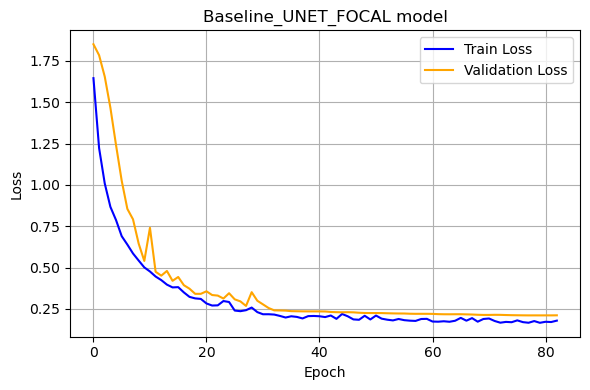

0.21071971952915192

In [ ]:
NUM_EPOCHS = 100

# model selection
MODEL_NAME = "Baseline_UNET_FOCAL"
model = UNet()

# loss function
criterion = FocalLoss()

# Optimizer와 scheduler 설정
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.1
)

# 학습 및 평가
train_fn(
    model=model.to(device),
    model_name=MODEL_NAME,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
)

#### 5-(3). DiceLoss

In [ ]:
# 메모리 정리 루틴
del model
del optimizer
gc.collect()
torch.cuda.empty_cache()
print(f"✅ Memory cleared for next run.")
print("=" * 40 + "\n")

✅ Memory cleared for next run.



In [ ]:
# (3) Dice Loss (foreground class 강조)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)  # (B, C, H, W)
        targets_onehot = (
            F.one_hot(targets, num_classes=logits.shape[1]).permute(0, 3, 1, 2).float()
        )

        intersection = (probs * targets_onehot).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets_onehot.sum(dim=(2, 3))
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

** Start training a model Baseline_UNET_DICE ** 


Epoch [1/100]: 100%|██████████| 4/4 [01:41<00:00, 25.47s/it]


Validation loss decreased (inf --> 0.947180).  Saving model ...
(Train Loss: 0.9420 | Val Loss: 0.9472)
***Val set evaluation*** mean IoU: 0.1185, pixel_accuracy: 0.3039


Epoch [2/100]: 100%|██████████| 4/4 [01:46<00:00, 26.50s/it]


Validation loss decreased (0.947180 --> 0.943883).  Saving model ...
(Train Loss: 0.9175 | Val Loss: 0.9439)
***Val set evaluation*** mean IoU: 0.1197, pixel_accuracy: 0.3040


Epoch [3/100]: 100%|██████████| 4/4 [01:45<00:00, 26.36s/it]


Validation loss decreased (0.943883 --> 0.937584).  Saving model ...
(Train Loss: 0.8965 | Val Loss: 0.9376)
***Val set evaluation*** mean IoU: 0.1396, pixel_accuracy: 0.5892


Epoch [4/100]: 100%|██████████| 4/4 [01:45<00:00, 26.26s/it]


Validation loss decreased (0.937584 --> 0.926360).  Saving model ...
(Train Loss: 0.8774 | Val Loss: 0.9264)
***Val set evaluation*** mean IoU: 0.1984, pixel_accuracy: 0.6740


Epoch [5/100]: 100%|██████████| 4/4 [01:45<00:00, 26.49s/it]


Validation loss decreased (0.926360 --> 0.909613).  Saving model ...
(Train Loss: 0.8592 | Val Loss: 0.9096)
***Val set evaluation*** mean IoU: 0.2300, pixel_accuracy: 0.7184


Epoch [6/100]: 100%|██████████| 4/4 [01:45<00:00, 26.47s/it]


Validation loss decreased (0.909613 --> 0.889002).  Saving model ...
(Train Loss: 0.8426 | Val Loss: 0.8890)
***Val set evaluation*** mean IoU: 0.2456, pixel_accuracy: 0.7369


Epoch [7/100]: 100%|██████████| 4/4 [01:47<00:00, 26.76s/it]


Validation loss decreased (0.889002 --> 0.862505).  Saving model ...
(Train Loss: 0.8310 | Val Loss: 0.8625)
***Val set evaluation*** mean IoU: 0.2611, pixel_accuracy: 0.7612


Epoch [8/100]: 100%|██████████| 4/4 [01:45<00:00, 26.32s/it]


Validation loss decreased (0.862505 --> 0.826554).  Saving model ...
(Train Loss: 0.8162 | Val Loss: 0.8266)
***Val set evaluation*** mean IoU: 0.2975, pixel_accuracy: 0.8018


Epoch [9/100]: 100%|██████████| 4/4 [01:44<00:00, 26.24s/it]


Validation loss decreased (0.826554 --> 0.803696).  Saving model ...
(Train Loss: 0.8066 | Val Loss: 0.8037)
***Val set evaluation*** mean IoU: 0.3434, pixel_accuracy: 0.8386


Epoch [10/100]: 100%|██████████| 4/4 [01:44<00:00, 26.21s/it]


Validation loss decreased (0.803696 --> 0.764183).  Saving model ...
(Train Loss: 0.7977 | Val Loss: 0.7642)
***Val set evaluation*** mean IoU: 0.3671, pixel_accuracy: 0.8512


Epoch [11/100]: 100%|██████████| 4/4 [01:45<00:00, 26.29s/it]


Validation loss decreased (0.764183 --> 0.749459).  Saving model ...
(Train Loss: 0.7883 | Val Loss: 0.7495)
***Val set evaluation*** mean IoU: 0.3770, pixel_accuracy: 0.8628


Epoch [12/100]: 100%|██████████| 4/4 [01:45<00:00, 26.27s/it]


Validation loss decreased (0.749459 --> 0.743725).  Saving model ...
(Train Loss: 0.7800 | Val Loss: 0.7437)
***Val set evaluation*** mean IoU: 0.3894, pixel_accuracy: 0.8806


Epoch [13/100]: 100%|██████████| 4/4 [01:44<00:00, 26.21s/it]


Validation loss decreased (0.743725 --> 0.738896).  Saving model ...
(Train Loss: 0.7752 | Val Loss: 0.7389)
***Val set evaluation*** mean IoU: 0.3924, pixel_accuracy: 0.8824


Epoch [14/100]: 100%|██████████| 4/4 [01:45<00:00, 26.27s/it]


Validation loss decreased (0.738896 --> 0.723045).  Saving model ...
(Train Loss: 0.7689 | Val Loss: 0.7230)
***Val set evaluation*** mean IoU: 0.3976, pixel_accuracy: 0.8895


Epoch [15/100]: 100%|██████████| 4/4 [01:44<00:00, 26.19s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.7595 | Val Loss: 0.7288)
***Val set evaluation*** mean IoU: 0.4056, pixel_accuracy: 0.8834


Epoch [16/100]: 100%|██████████| 4/4 [01:44<00:00, 26.17s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 0.7537 | Val Loss: 0.7266)
***Val set evaluation*** mean IoU: 0.4146, pixel_accuracy: 0.8945


Epoch [17/100]: 100%|██████████| 4/4 [01:43<00:00, 25.97s/it]


[Scheduler] Learning rate reduced: 0.000100 → 0.000010
EarlyStopping counter: 3 out of 5
(Train Loss: 0.7468 | Val Loss: 0.7253)
***Val set evaluation*** mean IoU: 0.4208, pixel_accuracy: 0.9017


Epoch [18/100]: 100%|██████████| 4/4 [01:43<00:00, 25.92s/it]


Validation loss decreased (0.723045 --> 0.720109).  Saving model ...
(Train Loss: 0.7444 | Val Loss: 0.7201)
***Val set evaluation*** mean IoU: 0.4316, pixel_accuracy: 0.9086


Epoch [19/100]: 100%|██████████| 4/4 [01:45<00:00, 26.28s/it]


Validation loss decreased (0.720109 --> 0.718851).  Saving model ...
(Train Loss: 0.7453 | Val Loss: 0.7189)
***Val set evaluation*** mean IoU: 0.4302, pixel_accuracy: 0.9037


Epoch [20/100]: 100%|██████████| 4/4 [01:45<00:00, 26.31s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.7437 | Val Loss: 0.7204)
***Val set evaluation*** mean IoU: 0.4277, pixel_accuracy: 0.8973


Epoch [21/100]: 100%|██████████| 4/4 [01:45<00:00, 26.29s/it]


Validation loss decreased (0.718851 --> 0.715782).  Saving model ...
(Train Loss: 0.7411 | Val Loss: 0.7158)
***Val set evaluation*** mean IoU: 0.4334, pixel_accuracy: 0.9046


Epoch [22/100]: 100%|██████████| 4/4 [01:44<00:00, 26.08s/it]


Validation loss decreased (0.715782 --> 0.714663).  Saving model ...
(Train Loss: 0.7399 | Val Loss: 0.7147)
***Val set evaluation*** mean IoU: 0.4367, pixel_accuracy: 0.9084


Epoch [23/100]: 100%|██████████| 4/4 [01:45<00:00, 26.25s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.7422 | Val Loss: 0.7161)
***Val set evaluation*** mean IoU: 0.4384, pixel_accuracy: 0.9083


Epoch [24/100]: 100%|██████████| 4/4 [01:44<00:00, 26.20s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 0.7395 | Val Loss: 0.7172)
***Val set evaluation*** mean IoU: 0.4377, pixel_accuracy: 0.9058


Epoch [25/100]: 100%|██████████| 4/4 [01:44<00:00, 26.00s/it]


Validation loss decreased (0.714663 --> 0.713717).  Saving model ...
(Train Loss: 0.7444 | Val Loss: 0.7137)
***Val set evaluation*** mean IoU: 0.4409, pixel_accuracy: 0.9118


Epoch [26/100]: 100%|██████████| 4/4 [01:44<00:00, 26.08s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.7375 | Val Loss: 0.7152)
***Val set evaluation*** mean IoU: 0.4407, pixel_accuracy: 0.9123


Epoch [27/100]: 100%|██████████| 4/4 [01:45<00:00, 26.33s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 0.7369 | Val Loss: 0.7173)
***Val set evaluation*** mean IoU: 0.4409, pixel_accuracy: 0.9113


Epoch [28/100]: 100%|██████████| 4/4 [01:44<00:00, 26.21s/it]


[Scheduler] Learning rate reduced: 0.000010 → 0.000001
EarlyStopping counter: 3 out of 5
(Train Loss: 0.7367 | Val Loss: 0.7151)
***Val set evaluation*** mean IoU: 0.4414, pixel_accuracy: 0.9113


Epoch [29/100]: 100%|██████████| 4/4 [01:44<00:00, 26.21s/it]


Validation loss decreased (0.713717 --> 0.713598).  Saving model ...
(Train Loss: 0.7365 | Val Loss: 0.7136)
***Val set evaluation*** mean IoU: 0.4413, pixel_accuracy: 0.9109


Epoch [30/100]: 100%|██████████| 4/4 [01:44<00:00, 26.21s/it]


Validation loss decreased (0.713598 --> 0.712520).  Saving model ...
(Train Loss: 0.7361 | Val Loss: 0.7125)
***Val set evaluation*** mean IoU: 0.4409, pixel_accuracy: 0.9107


Epoch [31/100]: 100%|██████████| 4/4 [01:44<00:00, 26.24s/it]


Validation loss decreased (0.712520 --> 0.711897).  Saving model ...
(Train Loss: 0.7365 | Val Loss: 0.7119)
***Val set evaluation*** mean IoU: 0.4411, pixel_accuracy: 0.9109


Epoch [32/100]: 100%|██████████| 4/4 [01:44<00:00, 26.15s/it]


Validation loss decreased (0.711897 --> 0.711377).  Saving model ...
(Train Loss: 0.7386 | Val Loss: 0.7114)
***Val set evaluation*** mean IoU: 0.4421, pixel_accuracy: 0.9109


Epoch [33/100]: 100%|██████████| 4/4 [01:45<00:00, 26.35s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.7363 | Val Loss: 0.7115)
***Val set evaluation*** mean IoU: 0.4419, pixel_accuracy: 0.9108


Epoch [34/100]: 100%|██████████| 4/4 [01:44<00:00, 26.11s/it]


Validation loss decreased (0.711377 --> 0.711312).  Saving model ...
(Train Loss: 0.7361 | Val Loss: 0.7113)
***Val set evaluation*** mean IoU: 0.4419, pixel_accuracy: 0.9107


Epoch [35/100]: 100%|██████████| 4/4 [01:45<00:00, 26.35s/it]


Validation loss decreased (0.711312 --> 0.711262).  Saving model ...
(Train Loss: 0.7355 | Val Loss: 0.7113)
***Val set evaluation*** mean IoU: 0.4420, pixel_accuracy: 0.9106


Epoch [36/100]: 100%|██████████| 4/4 [01:44<00:00, 26.15s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.7353 | Val Loss: 0.7113)
***Val set evaluation*** mean IoU: 0.4422, pixel_accuracy: 0.9107


Epoch [37/100]: 100%|██████████| 4/4 [01:43<00:00, 25.96s/it]


Validation loss decreased (0.711262 --> 0.710141).  Saving model ...
(Train Loss: 0.7412 | Val Loss: 0.7101)
***Val set evaluation*** mean IoU: 0.4423, pixel_accuracy: 0.9108


Epoch [38/100]: 100%|██████████| 4/4 [01:45<00:00, 26.30s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.7355 | Val Loss: 0.7102)
***Val set evaluation*** mean IoU: 0.4423, pixel_accuracy: 0.9109


Epoch [39/100]: 100%|██████████| 4/4 [01:44<00:00, 26.03s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 0.7368 | Val Loss: 0.7106)
***Val set evaluation*** mean IoU: 0.4423, pixel_accuracy: 0.9108


Epoch [40/100]: 100%|██████████| 4/4 [01:44<00:00, 26.14s/it]


Validation loss decreased (0.710141 --> 0.709882).  Saving model ...
(Train Loss: 0.7397 | Val Loss: 0.7099)
***Val set evaluation*** mean IoU: 0.4431, pixel_accuracy: 0.9113


Epoch [41/100]: 100%|██████████| 4/4 [01:44<00:00, 26.23s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.7359 | Val Loss: 0.7099)
***Val set evaluation*** mean IoU: 0.4427, pixel_accuracy: 0.9111


Epoch [42/100]: 100%|██████████| 4/4 [01:45<00:00, 26.33s/it]


Validation loss decreased (0.709882 --> 0.709646).  Saving model ...
(Train Loss: 0.7384 | Val Loss: 0.7096)
***Val set evaluation*** mean IoU: 0.4427, pixel_accuracy: 0.9112


Epoch [43/100]: 100%|██████████| 4/4 [01:44<00:00, 26.15s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.7356 | Val Loss: 0.7097)
***Val set evaluation*** mean IoU: 0.4429, pixel_accuracy: 0.9112


Epoch [44/100]: 100%|██████████| 4/4 [01:43<00:00, 25.99s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 0.7350 | Val Loss: 0.7100)
***Val set evaluation*** mean IoU: 0.4426, pixel_accuracy: 0.9110


Epoch [45/100]: 100%|██████████| 4/4 [01:44<00:00, 26.21s/it]


[Scheduler] Learning rate reduced: 0.000001 → 0.000000
EarlyStopping counter: 3 out of 5
(Train Loss: 0.7359 | Val Loss: 0.7103)
***Val set evaluation*** mean IoU: 0.4422, pixel_accuracy: 0.9105


Epoch [46/100]: 100%|██████████| 4/4 [01:43<00:00, 25.93s/it]


EarlyStopping counter: 4 out of 5
(Train Loss: 0.7359 | Val Loss: 0.7099)
***Val set evaluation*** mean IoU: 0.4424, pixel_accuracy: 0.9105


Epoch [47/100]: 100%|██████████| 4/4 [01:45<00:00, 26.30s/it]


EarlyStopping counter: 5 out of 5
Early stopping
Loading best model weights.


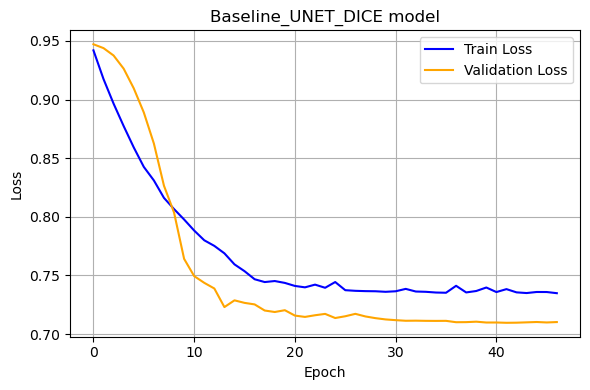

0.7096461057662964

In [ ]:
NUM_EPOCHS = 100

# model selection
MODEL_NAME = "Baseline_UNET_DICE"
model = UNet()

criterion = DiceLoss()

# Optimizer와 scheduler 설정
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.1
)

# 학습 및 평가
train_fn(
    model=model.to(device),
    model_name=MODEL_NAME,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
)

#### 2. Baseline UNET with Augmentations

In [ ]:
# 메모리 정리 루틴
del model
del optimizer
gc.collect()
torch.cuda.empty_cache()
print(f"✅ Memory cleared for next run.")
print("=" * 40 + "\n")

NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
# model selection
MODEL_NAME = "Baseline_UNET_Augmentation"
model = UNet()

# loss function
criterion = FocalLoss()

from torch.optim.lr_scheduler import CosineAnnealingLR

# Optimizer와 scheduler 설정
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, "min", patience=2, factor=0.1
# )
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

** Start training a model Baseline_UNET_Augmentation ** 


Epoch [1/100]: 100%|██████████| 4/4 [01:37<00:00, 24.36s/it]


Validation loss decreased (inf --> 1.982332).  Saving model ...
(Train Loss: 2.1726 | Val Loss: 1.9823)
***Val set evaluation*** mean IoU: 0.0018, pixel_accuracy: 0.0148


Epoch [2/100]: 100%|██████████| 4/4 [01:33<00:00, 23.46s/it]


Validation loss decreased (1.982332 --> 1.959925).  Saving model ...
(Train Loss: 1.8259 | Val Loss: 1.9599)
***Val set evaluation*** mean IoU: 0.0017, pixel_accuracy: 0.0147


Epoch [3/100]: 100%|██████████| 4/4 [01:33<00:00, 23.38s/it]


Validation loss decreased (1.959925 --> 1.892547).  Saving model ...
(Train Loss: 1.5903 | Val Loss: 1.8925)
***Val set evaluation*** mean IoU: 0.0111, pixel_accuracy: 0.0251


Epoch [4/100]: 100%|██████████| 4/4 [01:31<00:00, 22.79s/it]


Validation loss decreased (1.892547 --> 1.767317).  Saving model ...
(Train Loss: 1.4927 | Val Loss: 1.7673)
***Val set evaluation*** mean IoU: 0.0697, pixel_accuracy: 0.2180


Epoch [5/100]: 100%|██████████| 4/4 [01:31<00:00, 22.84s/it]


Validation loss decreased (1.767317 --> 1.595993).  Saving model ...
(Train Loss: 1.4034 | Val Loss: 1.5960)
***Val set evaluation*** mean IoU: 0.1630, pixel_accuracy: 0.5430


Epoch [6/100]: 100%|██████████| 4/4 [01:31<00:00, 22.80s/it]


Validation loss decreased (1.595993 --> 1.404393).  Saving model ...
(Train Loss: 1.2691 | Val Loss: 1.4044)
***Val set evaluation*** mean IoU: 0.1913, pixel_accuracy: 0.6439


Epoch [7/100]: 100%|██████████| 4/4 [01:31<00:00, 22.98s/it]


Validation loss decreased (1.404393 --> 1.241423).  Saving model ...
(Train Loss: 1.1997 | Val Loss: 1.2414)
***Val set evaluation*** mean IoU: 0.2022, pixel_accuracy: 0.6859


Epoch [8/100]: 100%|██████████| 4/4 [01:32<00:00, 23.04s/it]


Validation loss decreased (1.241423 --> 1.065428).  Saving model ...
(Train Loss: 1.1110 | Val Loss: 1.0654)
***Val set evaluation*** mean IoU: 0.2119, pixel_accuracy: 0.7109


Epoch [9/100]: 100%|██████████| 4/4 [01:31<00:00, 22.98s/it]


Validation loss decreased (1.065428 --> 0.985986).  Saving model ...
(Train Loss: 1.0991 | Val Loss: 0.9860)
***Val set evaluation*** mean IoU: 0.2170, pixel_accuracy: 0.7183


Epoch [10/100]: 100%|██████████| 4/4 [01:32<00:00, 23.11s/it]


Validation loss decreased (0.985986 --> 0.921463).  Saving model ...
(Train Loss: 1.1408 | Val Loss: 0.9215)
***Val set evaluation*** mean IoU: 0.2209, pixel_accuracy: 0.7261


Epoch [11/100]: 100%|██████████| 4/4 [01:31<00:00, 22.88s/it]


Validation loss decreased (0.921463 --> 0.861408).  Saving model ...
(Train Loss: 1.0407 | Val Loss: 0.8614)
***Val set evaluation*** mean IoU: 0.2232, pixel_accuracy: 0.7351


Epoch [12/100]: 100%|██████████| 4/4 [01:32<00:00, 23.07s/it]


Validation loss decreased (0.861408 --> 0.848065).  Saving model ...
(Train Loss: 1.0404 | Val Loss: 0.8481)
***Val set evaluation*** mean IoU: 0.2249, pixel_accuracy: 0.7369


Epoch [13/100]: 100%|██████████| 4/4 [01:32<00:00, 23.09s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 0.9136 | Val Loss: 0.8585)
***Val set evaluation*** mean IoU: 0.2245, pixel_accuracy: 0.7348


Epoch [14/100]: 100%|██████████| 4/4 [01:31<00:00, 22.95s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 0.9533 | Val Loss: 0.8715)
***Val set evaluation*** mean IoU: 0.2233, pixel_accuracy: 0.7341


Epoch [15/100]: 100%|██████████| 4/4 [01:31<00:00, 22.82s/it]


EarlyStopping counter: 3 out of 5
(Train Loss: 0.9887 | Val Loss: 0.8776)
***Val set evaluation*** mean IoU: 0.2250, pixel_accuracy: 0.7324


Epoch [16/100]: 100%|██████████| 4/4 [01:32<00:00, 23.06s/it]


EarlyStopping counter: 4 out of 5
(Train Loss: 0.9384 | Val Loss: 0.8640)
***Val set evaluation*** mean IoU: 0.2288, pixel_accuracy: 0.7404


Epoch [17/100]: 100%|██████████| 4/4 [01:31<00:00, 22.91s/it]


EarlyStopping counter: 5 out of 5
Early stopping
Loading best model weights.


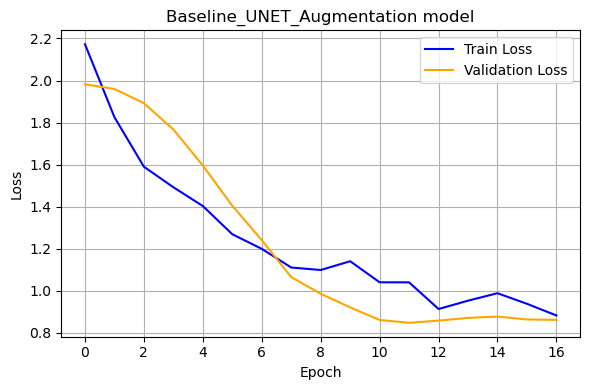

0.8480653166770935

In [ ]:
# Augmentation 적용
train_dataset = FootballDataset(
    train_files,
    train_masks,
    image_folder,
    color_to_label,
    transform=train_transform_v1,
)


train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)

# 학습 및 평가
train_fn(
    model=model.to(device),
    model_name=MODEL_NAME,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
)

✅ Memory cleared for next run.

** Start training a model Baseline_UNET_Augmentation ** 


Epoch [1/100]: 100%|██████████| 4/4 [01:32<00:00, 23.13s/it]


Validation loss decreased (inf --> 2.046148).  Saving model ...
(Train Loss: 2.2315 | Val Loss: 2.0461)
***Val set evaluation*** mean IoU: 0.0932, pixel_accuracy: 0.0146


Epoch [2/100]: 100%|██████████| 4/4 [01:25<00:00, 21.28s/it]


Validation loss decreased (2.046148 --> 2.039264).  Saving model ...
(Train Loss: 2.1811 | Val Loss: 2.0393)
***Val set evaluation*** mean IoU: 0.0110, pixel_accuracy: 0.0214


Epoch [3/100]: 100%|██████████| 4/4 [01:19<00:00, 19.99s/it]


Validation loss decreased (2.039264 --> 2.028811).  Saving model ...
(Train Loss: 2.0971 | Val Loss: 2.0288)
***Val set evaluation*** mean IoU: 0.0103, pixel_accuracy: 0.0255


Epoch [4/100]: 100%|██████████| 4/4 [01:20<00:00, 20.08s/it]


Validation loss decreased (2.028811 --> 2.014810).  Saving model ...
(Train Loss: 2.0928 | Val Loss: 2.0148)
***Val set evaluation*** mean IoU: 0.0100, pixel_accuracy: 0.0252


Epoch [5/100]: 100%|██████████| 4/4 [01:20<00:00, 20.03s/it]


Validation loss decreased (2.014810 --> 1.991099).  Saving model ...
(Train Loss: 1.9760 | Val Loss: 1.9911)
***Val set evaluation*** mean IoU: 0.0098, pixel_accuracy: 0.0250


Epoch [6/100]: 100%|██████████| 4/4 [01:21<00:00, 20.26s/it]


Validation loss decreased (1.991099 --> 1.954674).  Saving model ...
(Train Loss: 1.9081 | Val Loss: 1.9547)
***Val set evaluation*** mean IoU: 0.0369, pixel_accuracy: 0.1264


Epoch [7/100]: 100%|██████████| 4/4 [01:21<00:00, 20.30s/it]


Validation loss decreased (1.954674 --> 1.912941).  Saving model ...
(Train Loss: 1.8662 | Val Loss: 1.9129)
***Val set evaluation*** mean IoU: 0.0765, pixel_accuracy: 0.2680


Epoch [8/100]: 100%|██████████| 4/4 [01:21<00:00, 20.27s/it]


Validation loss decreased (1.912941 --> 1.868110).  Saving model ...
(Train Loss: 1.8704 | Val Loss: 1.8681)
***Val set evaluation*** mean IoU: 0.0963, pixel_accuracy: 0.3376


Epoch [9/100]: 100%|██████████| 4/4 [01:21<00:00, 20.28s/it]


Validation loss decreased (1.868110 --> 1.820294).  Saving model ...
(Train Loss: 1.8649 | Val Loss: 1.8203)
***Val set evaluation*** mean IoU: 0.1077, pixel_accuracy: 0.3772


Epoch [10/100]: 100%|██████████| 4/4 [01:20<00:00, 20.19s/it]


Validation loss decreased (1.820294 --> 1.762521).  Saving model ...
(Train Loss: 1.8088 | Val Loss: 1.7625)
***Val set evaluation*** mean IoU: 0.1174, pixel_accuracy: 0.4109


Epoch [11/100]: 100%|██████████| 4/4 [01:21<00:00, 20.26s/it]


Validation loss decreased (1.762521 --> 1.717194).  Saving model ...
(Train Loss: 1.7915 | Val Loss: 1.7172)
***Val set evaluation*** mean IoU: 0.1233, pixel_accuracy: 0.4306


Epoch [12/100]: 100%|██████████| 4/4 [01:20<00:00, 20.12s/it]


Validation loss decreased (1.717194 --> 1.680706).  Saving model ...
(Train Loss: 1.7601 | Val Loss: 1.6807)
***Val set evaluation*** mean IoU: 0.1278, pixel_accuracy: 0.4445


Epoch [13/100]: 100%|██████████| 4/4 [01:20<00:00, 20.10s/it]


Validation loss decreased (1.680706 --> 1.651016).  Saving model ...
(Train Loss: 1.6820 | Val Loss: 1.6510)
***Val set evaluation*** mean IoU: 0.1319, pixel_accuracy: 0.4540


Epoch [14/100]: 100%|██████████| 4/4 [01:20<00:00, 20.21s/it]


Validation loss decreased (1.651016 --> 1.616958).  Saving model ...
(Train Loss: 1.6436 | Val Loss: 1.6170)
***Val set evaluation*** mean IoU: 0.1362, pixel_accuracy: 0.4651


Epoch [15/100]: 100%|██████████| 4/4 [01:21<00:00, 20.26s/it]


Validation loss decreased (1.616958 --> 1.583160).  Saving model ...
(Train Loss: 1.6714 | Val Loss: 1.5832)
***Val set evaluation*** mean IoU: 0.1408, pixel_accuracy: 0.4798


Epoch [16/100]: 100%|██████████| 4/4 [01:20<00:00, 20.14s/it]


Validation loss decreased (1.583160 --> 1.544151).  Saving model ...
(Train Loss: 1.6308 | Val Loss: 1.5442)
***Val set evaluation*** mean IoU: 0.1463, pixel_accuracy: 0.4946


Epoch [17/100]: 100%|██████████| 4/4 [01:21<00:00, 20.42s/it]


Validation loss decreased (1.544151 --> 1.528008).  Saving model ...
(Train Loss: 1.6104 | Val Loss: 1.5280)
***Val set evaluation*** mean IoU: 0.1493, pixel_accuracy: 0.5005


Epoch [18/100]: 100%|██████████| 4/4 [01:20<00:00, 20.11s/it]


Validation loss decreased (1.528008 --> 1.506127).  Saving model ...
(Train Loss: 1.5497 | Val Loss: 1.5061)
***Val set evaluation*** mean IoU: 0.1534, pixel_accuracy: 0.5118


Epoch [19/100]: 100%|██████████| 4/4 [01:20<00:00, 20.11s/it]


Validation loss decreased (1.506127 --> 1.482092).  Saving model ...
(Train Loss: 1.4961 | Val Loss: 1.4821)
***Val set evaluation*** mean IoU: 0.1587, pixel_accuracy: 0.5260


Epoch [20/100]: 100%|██████████| 4/4 [01:21<00:00, 20.43s/it]


Validation loss decreased (1.482092 --> 1.454167).  Saving model ...
(Train Loss: 1.4573 | Val Loss: 1.4542)
***Val set evaluation*** mean IoU: 0.1627, pixel_accuracy: 0.5358


Epoch [21/100]: 100%|██████████| 4/4 [01:21<00:00, 20.26s/it]


Validation loss decreased (1.454167 --> 1.428031).  Saving model ...
(Train Loss: 1.4787 | Val Loss: 1.4280)
***Val set evaluation*** mean IoU: 0.1672, pixel_accuracy: 0.5485


Epoch [22/100]: 100%|██████████| 4/4 [01:20<00:00, 20.12s/it]


Validation loss decreased (1.428031 --> 1.411529).  Saving model ...
(Train Loss: 1.4766 | Val Loss: 1.4115)
***Val set evaluation*** mean IoU: 0.1697, pixel_accuracy: 0.5557


Epoch [23/100]: 100%|██████████| 4/4 [01:20<00:00, 20.11s/it]


Validation loss decreased (1.411529 --> 1.381961).  Saving model ...
(Train Loss: 1.4971 | Val Loss: 1.3820)
***Val set evaluation*** mean IoU: 0.1745, pixel_accuracy: 0.5724


Epoch [24/100]: 100%|██████████| 4/4 [01:21<00:00, 20.43s/it]


Validation loss decreased (1.381961 --> 1.360304).  Saving model ...
(Train Loss: 1.4002 | Val Loss: 1.3603)
***Val set evaluation*** mean IoU: 0.1781, pixel_accuracy: 0.5852


Epoch [25/100]: 100%|██████████| 4/4 [01:21<00:00, 20.35s/it]


Validation loss decreased (1.360304 --> 1.350378).  Saving model ...
(Train Loss: 1.3954 | Val Loss: 1.3504)
***Val set evaluation*** mean IoU: 0.1802, pixel_accuracy: 0.5909


Epoch [26/100]: 100%|██████████| 4/4 [01:20<00:00, 20.22s/it]


Validation loss decreased (1.350378 --> 1.331950).  Saving model ...
(Train Loss: 1.4234 | Val Loss: 1.3319)
***Val set evaluation*** mean IoU: 0.1820, pixel_accuracy: 0.5968


Epoch [27/100]: 100%|██████████| 4/4 [01:21<00:00, 20.40s/it]


Validation loss decreased (1.331950 --> 1.325030).  Saving model ...
(Train Loss: 1.3665 | Val Loss: 1.3250)
***Val set evaluation*** mean IoU: 0.1838, pixel_accuracy: 0.6001


Epoch [28/100]: 100%|██████████| 4/4 [01:20<00:00, 20.24s/it]


Validation loss decreased (1.325030 --> 1.321816).  Saving model ...
(Train Loss: 1.3613 | Val Loss: 1.3218)
***Val set evaluation*** mean IoU: 0.1848, pixel_accuracy: 0.5999


Epoch [29/100]: 100%|██████████| 4/4 [01:20<00:00, 20.07s/it]


Validation loss decreased (1.321816 --> 1.309049).  Saving model ...
(Train Loss: 1.3284 | Val Loss: 1.3090)
***Val set evaluation*** mean IoU: 0.1864, pixel_accuracy: 0.6032


Epoch [30/100]: 100%|██████████| 4/4 [01:21<00:00, 20.43s/it]


Validation loss decreased (1.309049 --> 1.289930).  Saving model ...
(Train Loss: 1.3089 | Val Loss: 1.2899)
***Val set evaluation*** mean IoU: 0.1888, pixel_accuracy: 0.6094


Epoch [31/100]: 100%|██████████| 4/4 [01:21<00:00, 20.37s/it]


Validation loss decreased (1.289930 --> 1.260617).  Saving model ...
(Train Loss: 1.3075 | Val Loss: 1.2606)
***Val set evaluation*** mean IoU: 0.1923, pixel_accuracy: 0.6227


Epoch [32/100]: 100%|██████████| 4/4 [01:20<00:00, 20.21s/it]


Validation loss decreased (1.260617 --> 1.243285).  Saving model ...
(Train Loss: 1.2903 | Val Loss: 1.2433)
***Val set evaluation*** mean IoU: 0.1941, pixel_accuracy: 0.6297


Epoch [33/100]: 100%|██████████| 4/4 [01:20<00:00, 20.16s/it]


Validation loss decreased (1.243285 --> 1.237653).  Saving model ...
(Train Loss: 1.2353 | Val Loss: 1.2377)
***Val set evaluation*** mean IoU: 0.1955, pixel_accuracy: 0.6339


Epoch [34/100]: 100%|██████████| 4/4 [01:21<00:00, 20.43s/it]


Validation loss decreased (1.237653 --> 1.212897).  Saving model ...
(Train Loss: 1.3244 | Val Loss: 1.2129)
***Val set evaluation*** mean IoU: 0.1975, pixel_accuracy: 0.6437


Epoch [35/100]: 100%|██████████| 4/4 [01:21<00:00, 20.40s/it]


Validation loss decreased (1.212897 --> 1.195889).  Saving model ...
(Train Loss: 1.2545 | Val Loss: 1.1959)
***Val set evaluation*** mean IoU: 0.2023, pixel_accuracy: 0.6532


Epoch [36/100]: 100%|██████████| 4/4 [01:21<00:00, 20.26s/it]


Validation loss decreased (1.195889 --> 1.189109).  Saving model ...
(Train Loss: 1.2194 | Val Loss: 1.1891)
***Val set evaluation*** mean IoU: 0.2027, pixel_accuracy: 0.6518


Epoch [37/100]: 100%|██████████| 4/4 [01:21<00:00, 20.30s/it]


Validation loss decreased (1.189109 --> 1.184608).  Saving model ...
(Train Loss: 1.1871 | Val Loss: 1.1846)
***Val set evaluation*** mean IoU: 0.2038, pixel_accuracy: 0.6533


Epoch [38/100]: 100%|██████████| 4/4 [01:20<00:00, 20.15s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 1.2032 | Val Loss: 1.1962)
***Val set evaluation*** mean IoU: 0.2045, pixel_accuracy: 0.6519


Epoch [39/100]: 100%|██████████| 4/4 [01:21<00:00, 20.40s/it]


Validation loss decreased (1.184608 --> 1.182278).  Saving model ...
(Train Loss: 1.3029 | Val Loss: 1.1823)
***Val set evaluation*** mean IoU: 0.2063, pixel_accuracy: 0.6626


Epoch [40/100]: 100%|██████████| 4/4 [01:21<00:00, 20.27s/it]


Validation loss decreased (1.182278 --> 1.159247).  Saving model ...
(Train Loss: 1.1906 | Val Loss: 1.1592)
***Val set evaluation*** mean IoU: 0.2104, pixel_accuracy: 0.6728


Epoch [41/100]: 100%|██████████| 4/4 [01:21<00:00, 20.28s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 1.2264 | Val Loss: 1.1598)
***Val set evaluation*** mean IoU: 0.2089, pixel_accuracy: 0.6670


Epoch [42/100]: 100%|██████████| 4/4 [01:20<00:00, 20.18s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 1.1323 | Val Loss: 1.1775)
***Val set evaluation*** mean IoU: 0.2056, pixel_accuracy: 0.6587


Epoch [43/100]: 100%|██████████| 4/4 [01:21<00:00, 20.29s/it]


EarlyStopping counter: 3 out of 5
(Train Loss: 1.2520 | Val Loss: 1.1746)
***Val set evaluation*** mean IoU: 0.2070, pixel_accuracy: 0.6604


Epoch [44/100]: 100%|██████████| 4/4 [01:20<00:00, 20.25s/it]


Validation loss decreased (1.159247 --> 1.149097).  Saving model ...
(Train Loss: 1.1596 | Val Loss: 1.1491)
***Val set evaluation*** mean IoU: 0.2110, pixel_accuracy: 0.6738


Epoch [45/100]: 100%|██████████| 4/4 [01:21<00:00, 20.39s/it]


Validation loss decreased (1.149097 --> 1.145031).  Saving model ...
(Train Loss: 1.1099 | Val Loss: 1.1450)
***Val set evaluation*** mean IoU: 0.2112, pixel_accuracy: 0.6784


Epoch [46/100]: 100%|██████████| 4/4 [01:20<00:00, 20.20s/it]


Validation loss decreased (1.145031 --> 1.113118).  Saving model ...
(Train Loss: 1.1336 | Val Loss: 1.1131)
***Val set evaluation*** mean IoU: 0.2139, pixel_accuracy: 0.6895


Epoch [47/100]: 100%|██████████| 4/4 [01:21<00:00, 20.42s/it]


Validation loss decreased (1.113118 --> 1.103754).  Saving model ...
(Train Loss: 1.1180 | Val Loss: 1.1038)
***Val set evaluation*** mean IoU: 0.2163, pixel_accuracy: 0.6927


Epoch [48/100]: 100%|██████████| 4/4 [01:20<00:00, 20.24s/it]


EarlyStopping counter: 1 out of 5
(Train Loss: 1.1548 | Val Loss: 1.1337)
***Val set evaluation*** mean IoU: 0.2141, pixel_accuracy: 0.6786


Epoch [49/100]: 100%|██████████| 4/4 [01:20<00:00, 20.20s/it]


EarlyStopping counter: 2 out of 5
(Train Loss: 1.1304 | Val Loss: 1.1606)
***Val set evaluation*** mean IoU: 0.2090, pixel_accuracy: 0.6616


Epoch [50/100]: 100%|██████████| 4/4 [01:20<00:00, 20.07s/it]


EarlyStopping counter: 3 out of 5
(Train Loss: 1.1278 | Val Loss: 1.1591)
***Val set evaluation*** mean IoU: 0.2085, pixel_accuracy: 0.6610


Epoch [51/100]: 100%|██████████| 4/4 [01:21<00:00, 20.41s/it]


EarlyStopping counter: 4 out of 5
(Train Loss: 1.1026 | Val Loss: 1.1724)
***Val set evaluation*** mean IoU: 0.2060, pixel_accuracy: 0.6494


Epoch [52/100]: 100%|██████████| 4/4 [01:20<00:00, 20.12s/it]


EarlyStopping counter: 5 out of 5
Early stopping
Loading best model weights.


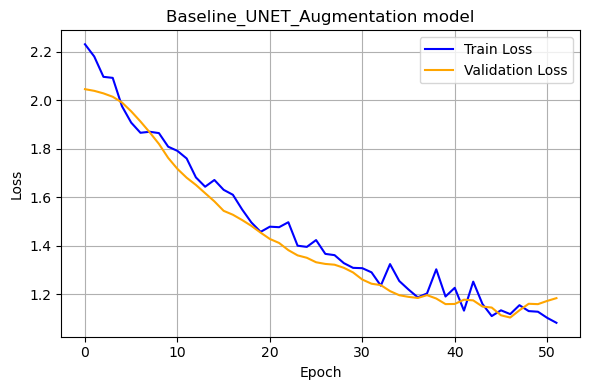

1.1037544012069702

In [ ]:
# 메모리 정리 루틴
del model
del optimizer
gc.collect()
torch.cuda.empty_cache()
print(f"✅ Memory cleared for next run.")
print("=" * 40 + "\n")

NUM_EPOCHS = 100
LEARNING_RATE = 1e-5
# model selection
MODEL_NAME = "Baseline_UNET_Augmentation"
model = UNet()

# loss function
# Optimizer와 scheduler 설정
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, "min", patience=2, factor=0.1
# )

# Augmentation 적용
train_dataset = FootballDataset(
    train_files,
    train_masks,
    image_folder,
    color_to_label,
    transform=train_transform_v1,
)


train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)

# 학습 및 평가
train_fn(
    model=model.to(device),
    model_name=MODEL_NAME,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
)

## 6. Results & Disscussion

이번 과제에서는 football-semantic-segmentation 데이터를 사용하여 Sementic sementation를 실습해보는 과제였다.  결과를 잠시 살펴보면

1. Without Data Augmenation
    1) baseline model(cross Entropy): mean IoU: 0.5516, pixel_accuracy: 0.9343
    2) baseline model(Focal): mean IoU: 0.5661, pixel_accuracy: 0.9356
    3) baseline model(dice): mean IoU: 0.4427, pixel_accuracy: 0.9112
2. With Data Augmenation 
    1) Scehduler-cosine Anealing: mean IoU: 0.2249, pixel_accuracy: 0.7369
    2) scheudler-ReduceLROnPlateau: mean IoU: 0.2163, pixel_accuracy: 0.6927


코드는 baseline에서 주어진 UNET을 활용하였고 기본적인 과제 수행을 위해서 데이터 전처리부터 학습까지 진행을 하였다.

일단 이번 과제의 특징은  
    (1) 데이터가 단 100 pair 뿐이었다는 것이다. 한정된 데이터를 가졌을때 최대한 이를 활용하려는 시도가 필요하여 높은 수준의 data augmentation을 진행하였다. 따라서 torchvision 라이브러리보다 더 고수준의 Albumentations라는 패키지를 활용하였다.

    (2) class는 11개였고 대부분의 data segmentation이 그러하듯이 class 간에 imbalance가 존재하였다. 이를 위해서 loss function을 CrossEntropy의 발전 버전인 Focal loss를 사용하였다. 그 결과 CrossEntropy보다 소폭 상승된 성능을 보여주었다.

    (3) Data Augmentation은 부족한 데이터를 증강시켜주는 의미도 있지만 과도한 경우 모델의 성능을 떨어뜨릴 수 있다. 본 과제에서는 높은 수준의 Augmentation이 진행되었지만 결과적으로 성능을 극복할만큼의 수준이 아니었고 여러가지 하이퍼파라미터를 고쳐봤지만 성능의 한계를 극복하지 못했다. 아마도 충분한 모델의 파라미터의 숫자의 부족을 극복하지 못한것 같다.

    (4) Learning rate의 튜닝을 위해서 스케줄러를 안정적인 cosine으로 바꾸었더니 조금 더 성능은 개선되었지만 Augmentation이 강한 관계로 학습은 불안정했고 성능도 낮아졌다.

    (5) 과제 내내 사용했던 earlystopping에 대해서 만능키가 아니라는 것을 알게 되었으며 이렇게 불안정한 학습의 경우 그냥 학습을 진행하는 것이 더 좋은 판단이라는 것도 생각해보았다. 

과제의 목표를 적절하게 Augmentation을 하고 모델의 최종 학습을 Cross validation으로ㅠ 진행하려고 했지만 적절한 Augmentation과 하이퍼파라미터 튜닝이 크게 시간을 잡아 먹었으며 이를 극복하려고 여러 시도해봤다는 것에 의의를 두는 과제이다.